In [86]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import datasets

In [ ]:
# Charger le jeu de données de test et d'entraînement
df_train = pd.read_csv('train_Insurance.csv')
df_test = pd.read_csv('test_Insurance.csv')

# Afficher les 5 premières lignes du jeu de données
df_train.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,NumberOfWindows,Geo_Code,Claim
0,H13501,2012,1.0,1,N,V,V,U,1240.0,Wood-framed,without,75117,non
1,H14962,2012,1.0,0,N,V,V,U,900.0,Non-combustible,without,62916,non
2,H17755,2013,1.0,1,V,N,O,R,4984.0,Non-combustible,4,31149,oui
3,H13369,2016,0.5,0,N,V,V,U,600.0,Wood-framed,without,6012,oui
4,H12988,2012,1.0,0,N,V,V,U,900.0,Non-combustible,without,57631,non


In [88]:
# Afficher les informations du jeu de données
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5012 entries, 0 to 5011
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         5012 non-null   object 
 1   YearOfObservation   5012 non-null   int64  
 2   Insured_Period      5012 non-null   float64
 3   Residential         5012 non-null   int64  
 4   Building_Painted    5012 non-null   object 
 5   Building_Fenced     5012 non-null   object 
 6   Garden              5008 non-null   object 
 7   Settlement          5012 non-null   object 
 8   Building Dimension  4935 non-null   float64
 9   Building_Type       5012 non-null   object 
 10  NumberOfWindows     5012 non-null   object 
 11  Geo_Code            4939 non-null   object 
 12  Claim               5012 non-null   object 
dtypes: float64(2), int64(2), object(9)
memory usage: 509.2+ KB


In [89]:
# Afficher les statistiques descriptives du jeu de données
df_train.describe(include='all')

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,NumberOfWindows,Geo_Code,Claim
count,5012,5012.000000,5012.000000,5012.000000,5012,5012,5008,5012,4935.000000,5012,5012,4939,5012
unique,5012,NaN,NaN,NaN,2,2,2,2,NaN,4,11,1115,2
top,H18228,NaN,NaN,NaN,V,N,O,R,NaN,Non-combustible,without,6088,non
freq,1,NaN,NaN,NaN,3763,2535,2532,2537,NaN,2310,2476,102,3886
mean,NaN,2013.660215,0.869713,0.301077,NaN,NaN,NaN,NaN,1876.898683,NaN,NaN,NaN,NaN
std,NaN,1.383134,0.219496,0.458772,NaN,NaN,NaN,NaN,2267.277397,NaN,NaN,NaN,NaN
min,NaN,2012.000000,0.500000,0.000000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
25%,NaN,2012.000000,0.500000,0.000000,NaN,NaN,NaN,NaN,520.000000,NaN,NaN,NaN,NaN
50%,NaN,2013.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,1067.000000,NaN,NaN,NaN,NaN
75%,NaN,2015.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,2280.000000,NaN,NaN,NaN,NaN


In [90]:
# Vérification des valeurs manquantes
df_train.isnull().sum()

Customer Id            0
YearOfObservation      0
Insured_Period         0
Residential            0
Building_Painted       0
Building_Fenced        0
Garden                 4
Settlement             0
Building Dimension    77
Building_Type          0
NumberOfWindows        0
Geo_Code              73
Claim                  0
dtype: int64

In [91]:
# Vérification des valeurs dupliquées
dup = df_train.duplicated().sum()
print("Les valeurs dupliquées sont : ", dup)

Les valeurs dupliquées sont :  0


In [92]:
from sklearn.impute import SimpleImputer
def Traitement_data(data):
    data.drop_duplicates(inplace=True,ignore_index=True)
    #fill Nan Values
    mostFrequentImputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    medianImputer = SimpleImputer(missing_values=np.nan , strategy='median')
    data[['Garden']]=mostFrequentImputer.fit_transform(data.loc[:,['Garden']])
    data[['Geo_Code']]=mostFrequentImputer.fit_transform(data.loc[:,['Geo_Code']])
    data[['Building Dimension']] = medianImputer.fit_transform(data[['Building Dimension']])
    data["NumberOfWindows"].replace({"without": 0, ">=10": 10}, inplace=True)
    # Filtrer les valeurs aberrantes
    Q1,Q3=np.percentile(data["Building Dimension"],[25,75])
    IQR=Q3-Q1
    upper_limit=Q3+1.5*IQR
    lower_limit=Q1-1.5*IQR
    data['Building Dimension']=np.where(data['Building Dimension']>upper_limit,upper_limit, 
                                        np.where(data['Building Dimension']<lower_limit, 
                                        lower_limit,data['Building Dimension']))
    return data

In [93]:
from sklearn.preprocessing import RobustScaler, QuantileTransformer

def Transformation_data(data):
    # Transformation des données
    data = pd.get_dummies(
        data,
        columns=["Building_Painted", "Building_Fenced", "Garden", "Settlement"],
        dtype="int32",
    )
    data = pd.get_dummies(
        data, columns=["Building_Type"], dtype="int32", prefix="", prefix_sep=""
    )
    robust_scaler = RobustScaler()
    data[["Building Dimension"]] = robust_scaler.fit_transform(
        data[["Building Dimension"]]
    )

    transformer = QuantileTransformer(output_distribution="uniform")
    data[["YearOfObservation"]] = transformer.fit_transform(data[["YearOfObservation"]])

    return data

In [94]:
# Retourner les colonnes numériques et catégorielles
def liste_num(data):
    return list(data._get_numeric_data().columns)

def liste_dis(data):
    return list(set(data.columns)-set(liste_num(data)))


In [95]:
def Selection_descripteurs(data):
    # Liste des descripteurs discréts
    l_discret = liste_dis(data)
    plt.figure(figsize=(20, 20))
    for i in range(len(l_discret)):
        plt.subplot(3, 3, i + 1)
        sns.countplot(x=l_discret[i], data=data)
    plt.show()

In [96]:
def drop_columns(data):
    data.drop(["Geo_Code", "Customer Id", "NumberOfWindows"], axis=1, inplace=True)

    numeric_data = data.select_dtypes(include=[np.number])
    corr_matrix = numeric_data.corr().abs()

    # Seuil de corrélation
    threshold = 0.8

    # 1. Identifier les paires de variables fortement corrélées
    high_corr_pairs = np.where(corr_matrix > threshold)
    high_corr_pairs = [
        (corr_matrix.index[x], corr_matrix.columns[y])
        for x, y in zip(*high_corr_pairs)
        if x != y and x < y
    ]

    print("Paires fortement corrélées :", high_corr_pairs)

    # 2. Suppression des colonnes fortement corrélées
    features_to_drop = set()
    for pair in high_corr_pairs:
        features_to_drop.add(pair[1])  # Ajouter la colonne à éliminer

    df_reduced = data.drop(columns=features_to_drop)

    print("Features à éliminer:", features_to_drop)
    print("DataFrame réduite:\n", df_reduced)

    # Déplacer la colonne 'Claim' à la fin
    col_order = [col for col in df_reduced.columns if col != "Claim"] + ["Claim"]
    data = df_reduced[col_order]
    return data

In [97]:
# Fonction pour afficher la distribution des données
def distribution(data, x, bins=3):
    plt.Figure(figsize=(10, 5))
    sns.histplot( x=x, data=data ,bins=bins, kde=True, stat='density')
    plt.show()

In [98]:
# Fonction pour afficher la matrice de corrélation
def matrice_correlation(data):
    numeric_data = data.corr(numeric_only=True)
    fig = plt.figure(figsize=(25, 20))
    sns.heatmap(numeric_data, annot=True, fmt=".3f", vmin=-1, vmax=1, cmap="coolwarm")
    plt.show()

In [99]:
from scipy.stats import chi2_contingency


def chi(data, x, visualize=True):
    # Visualisation de la distribution de la variable x par rapport à la variable cible
    if visualize:
        sns.countplot(data=data, x=x, hue="Claim")
        plt.xticks(rotation=90)
        plt.title("Claim Distribution Across {}".format(x))
        plt.show()

    # Créer un tableau de contingence
    contingency_table = pd.crosstab(data[x], data["Claim"])

    # Test du Chi-Square
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-Square Statistic: {chi2}")
    print(f"P-value: {p}")

    # Interpretation
    if p < 0.05:
        print("Il existe une relation de signification entre X {} et Claim.".format(x))
    else:
        print("Il n'y a pas de relation significative entre {} et Claim".format(x))

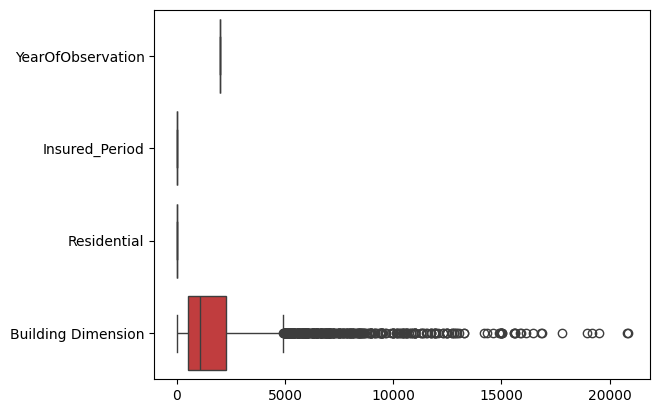

In [ ]:
# Visualisation des données aberrantes
sns.boxplot(data=df_train[liste_num(df_train)], orient="h")
plt.show()

In [ ]:
# Traitement des données de train
df_train = Traitement_data(df_train)
df_train.isna().sum()

/tmp/ipykernel_45747/397716719.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["NumberOfWindows"].replace({"without": 0, ">=10": 10}, inplace=True)


Customer Id           0
YearOfObservation     0
Insured_Period        0
Residential           0
Building_Painted      0
Building_Fenced       0
Garden                0
Settlement            0
Building Dimension    0
Building_Type         0
NumberOfWindows       0
Geo_Code              0
Claim                 0
dtype: int64

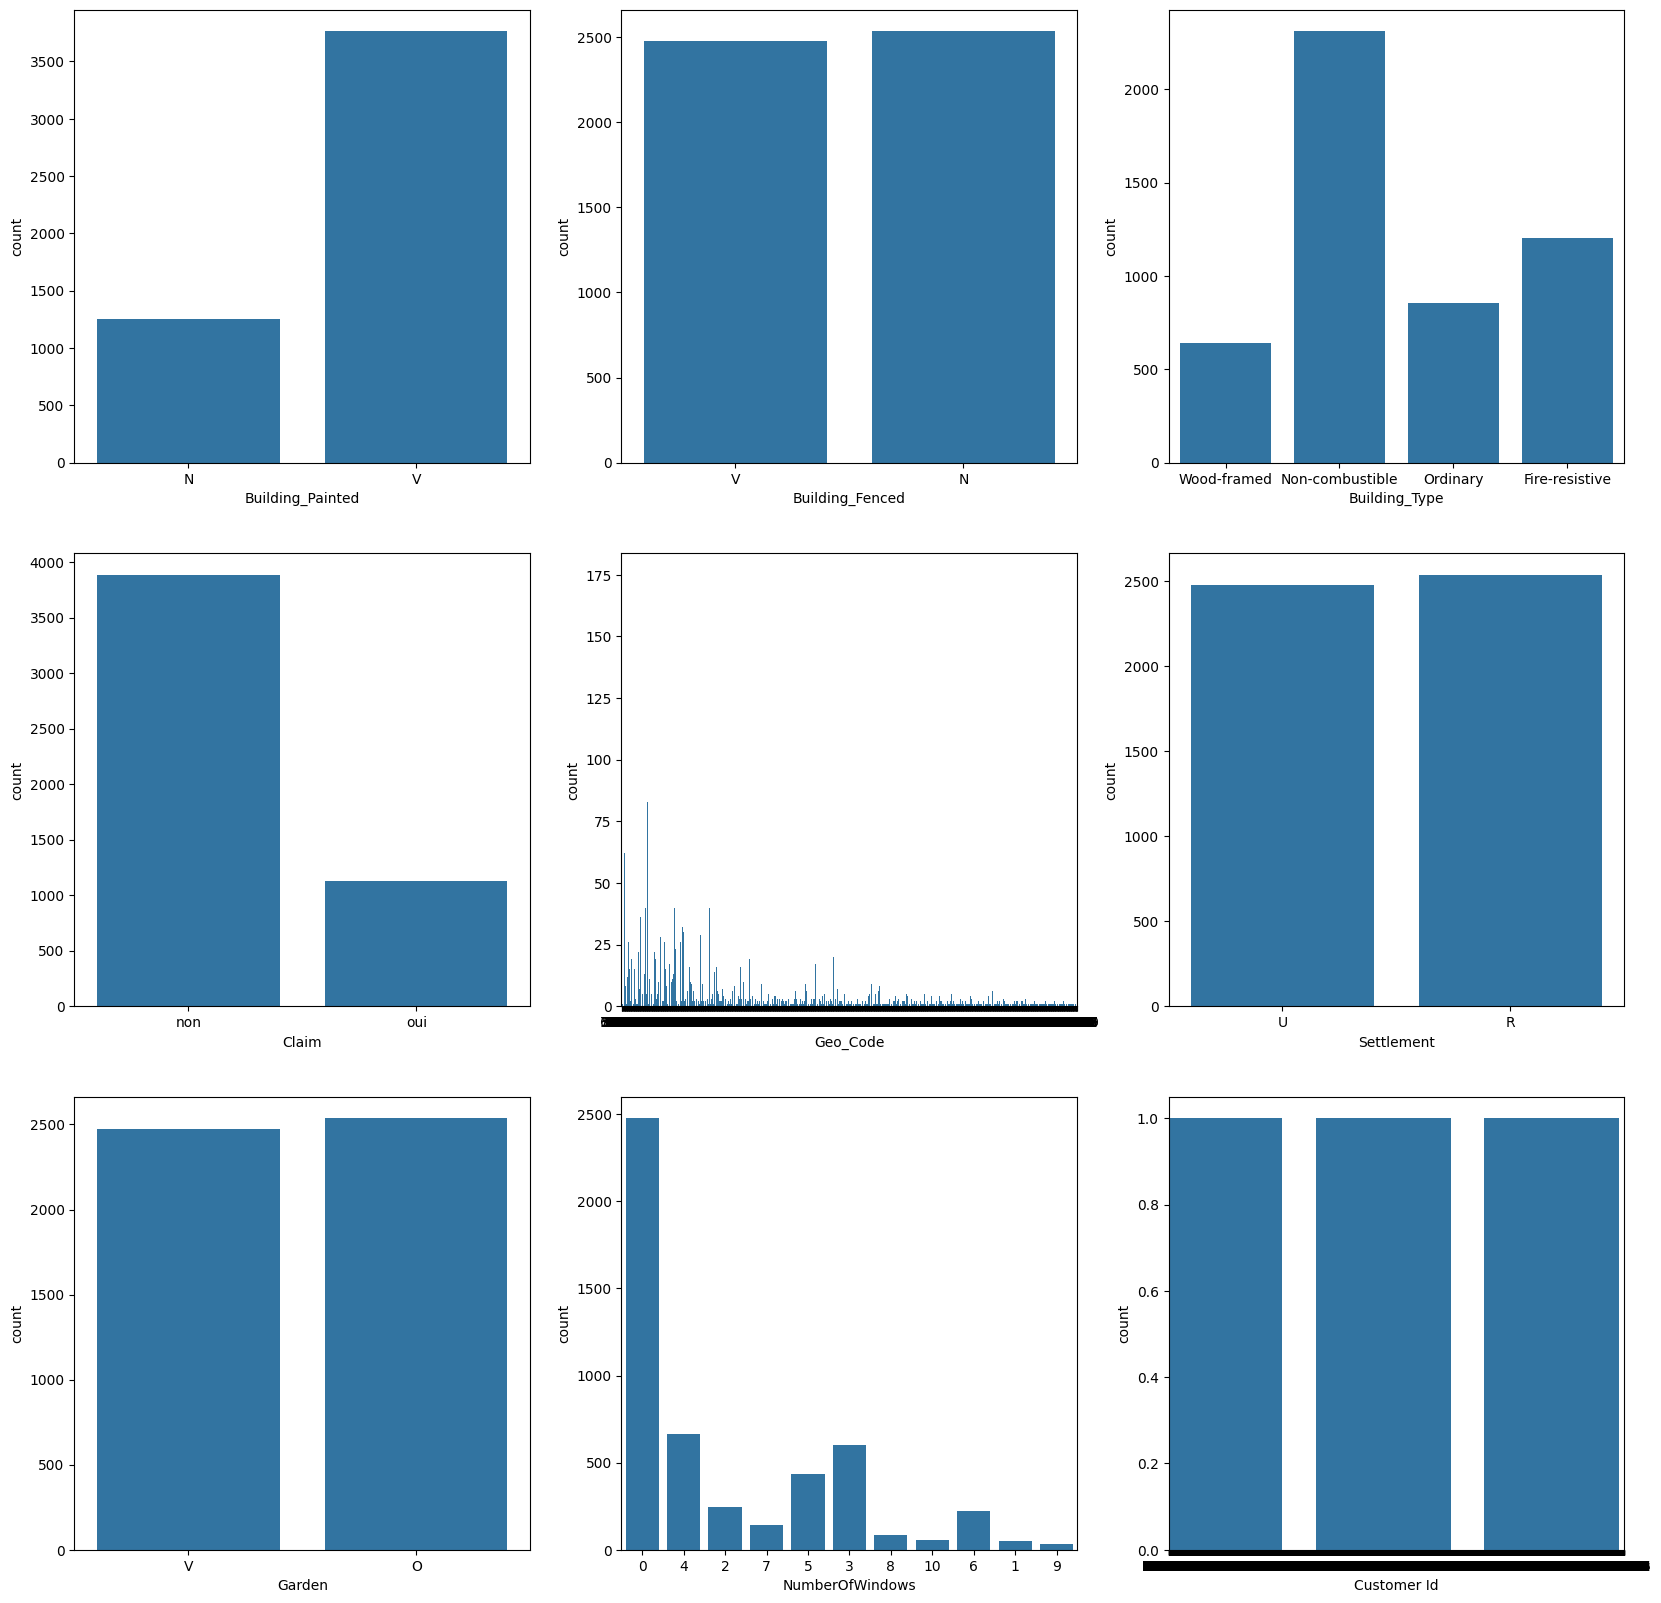

In [102]:
# Affichage des nombres d'observations pour chaque bin catégoriel
Selection_descripteurs(df_train)

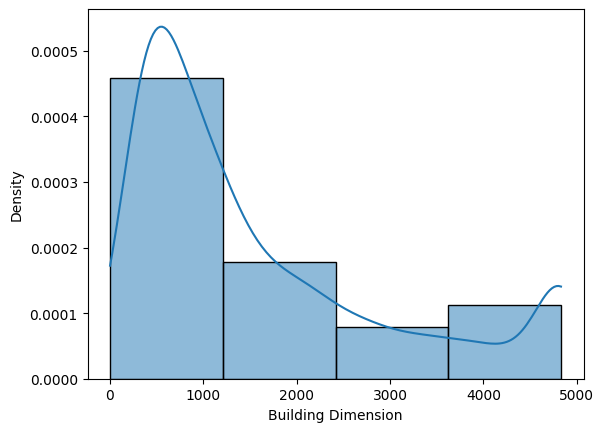

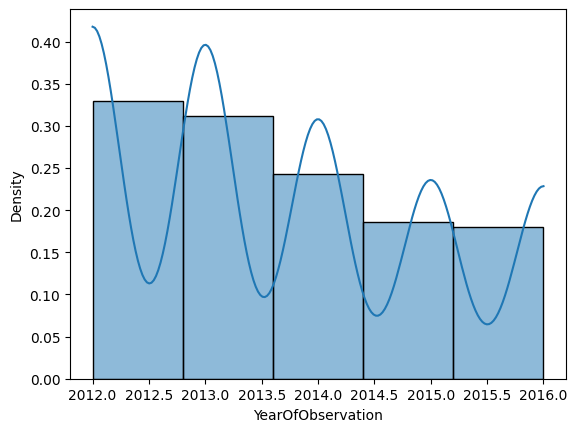

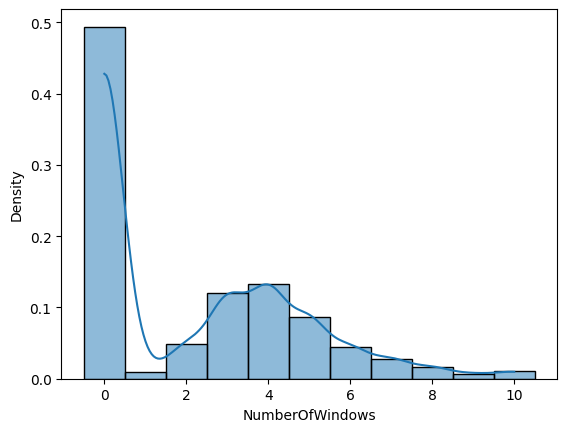

In [ ]:
# Affichage des distributions des variables numériques
distribution(df_train, 'Building Dimension', bins=4)
distribution(df_train, 'YearOfObservation', bins=5)
distribution(df_train, 'NumberOfWindows')

In [104]:
# Transformation des données de train
df_train = Transformation_data(df_train)

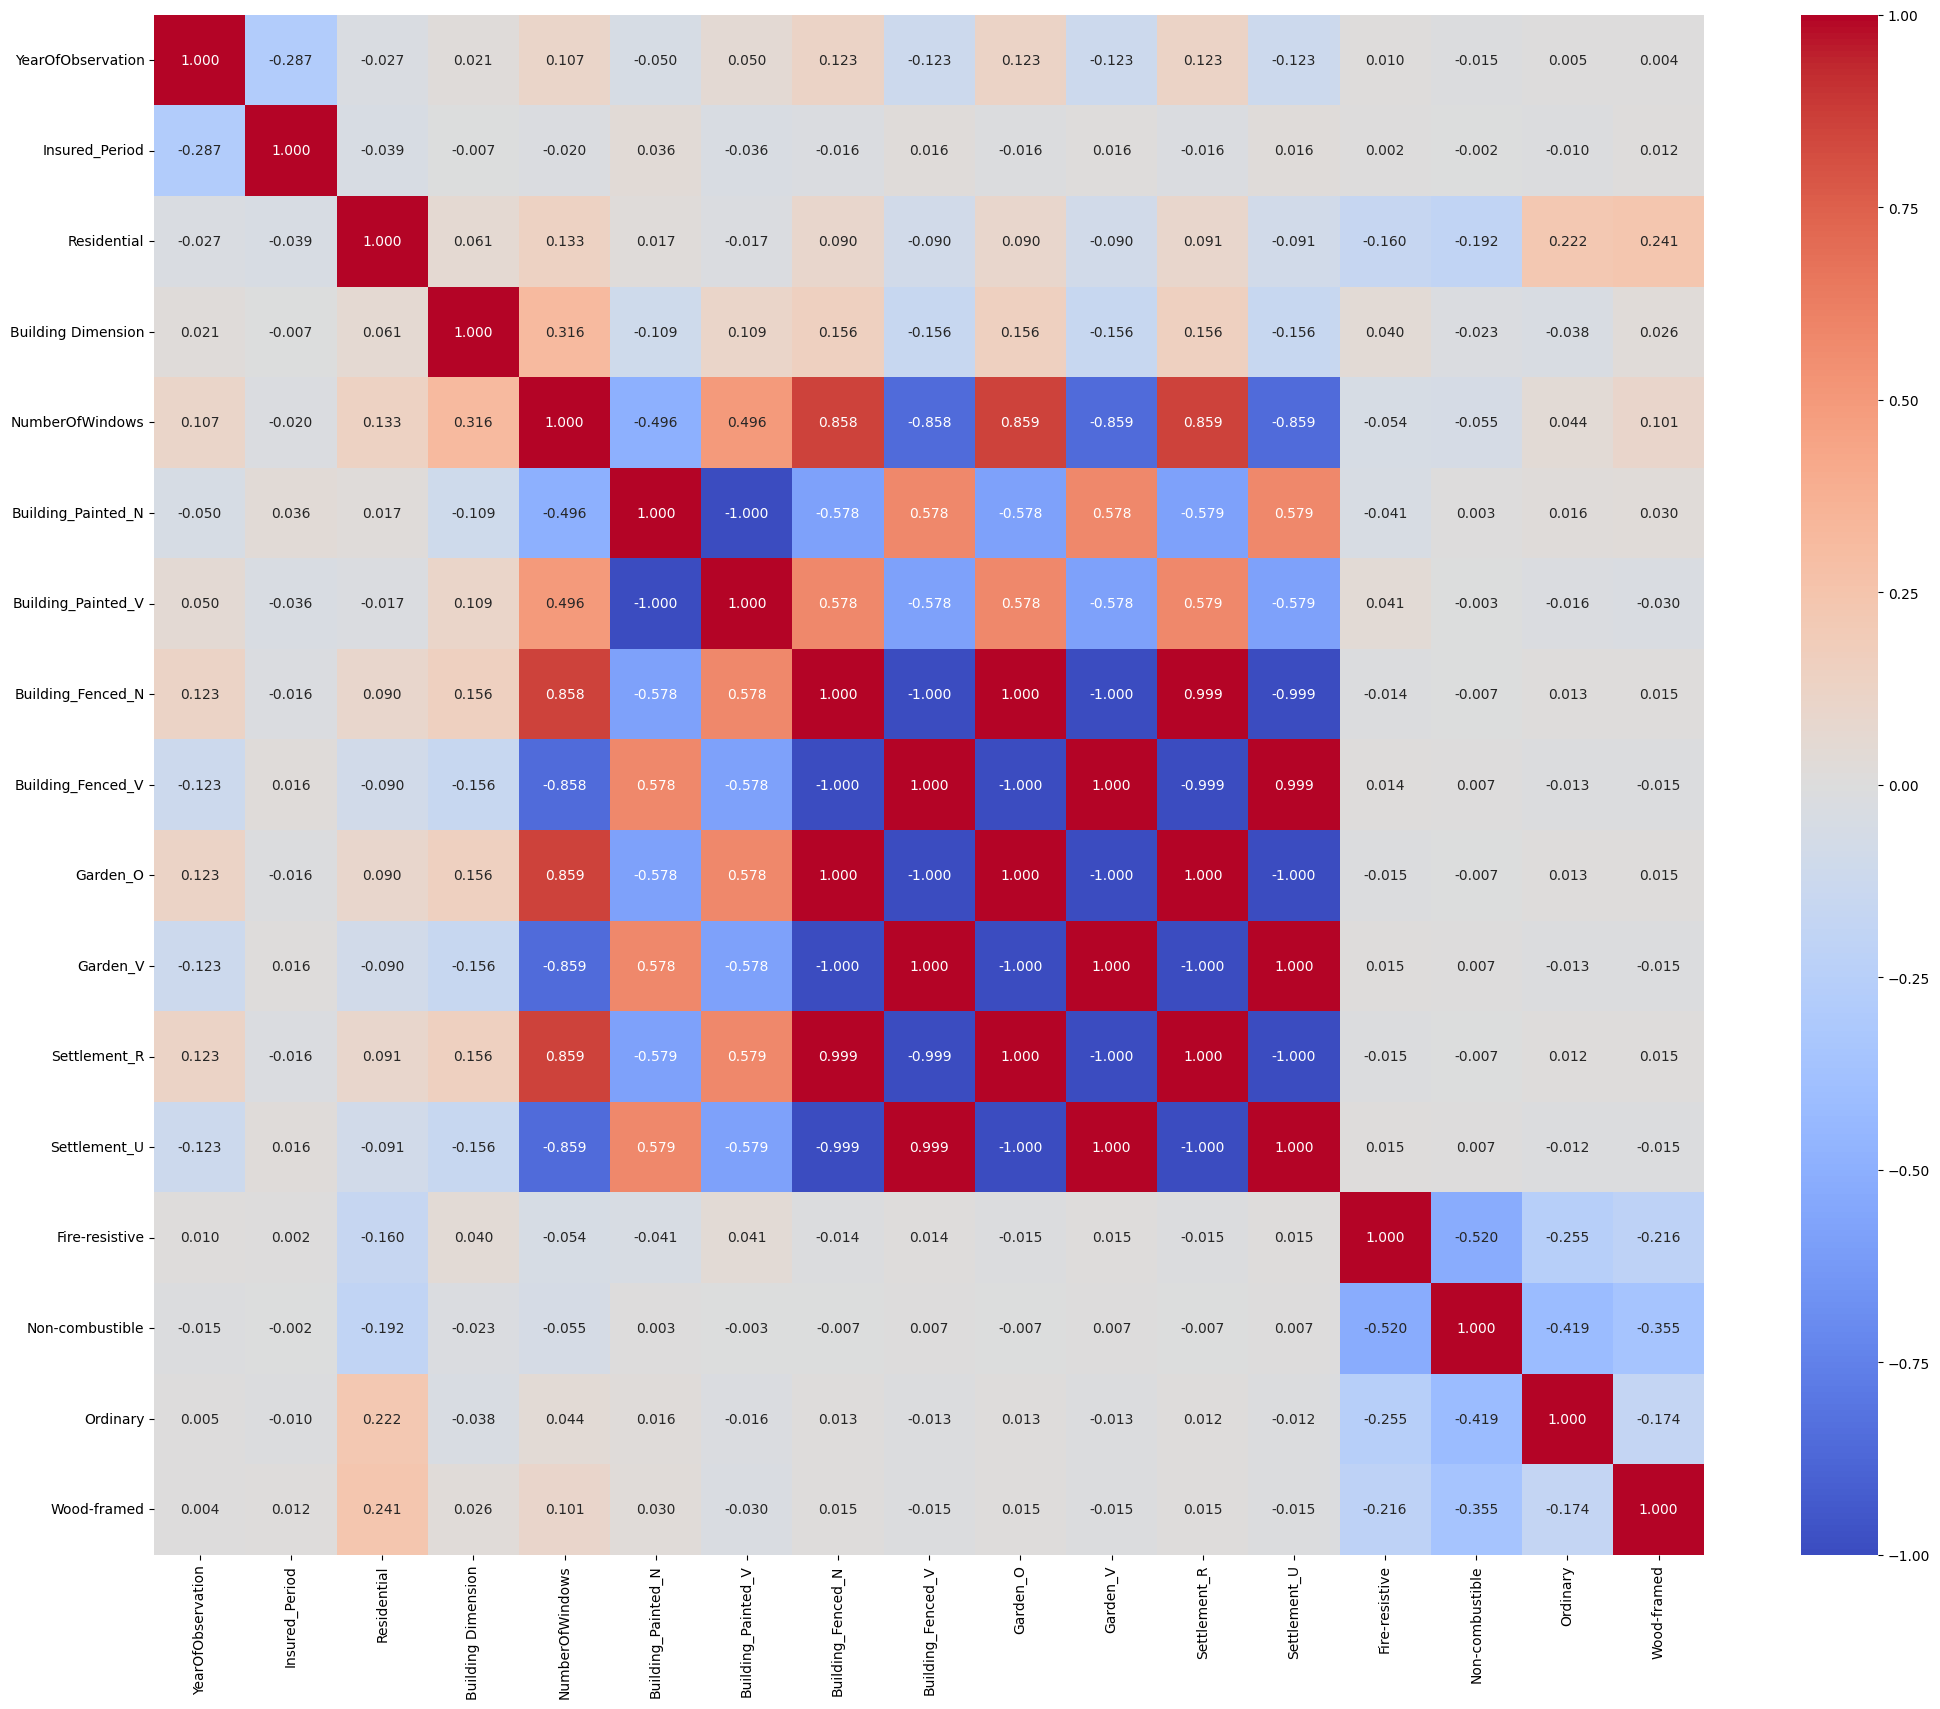

In [ ]:
# Affichage de la matrice de corrélation
df_train['NumberOfWindows'] = df_train['NumberOfWindows'].astype('int32')
matrice_correlation(df_train)

In [ ]:
# Lancement du test du Chi-Square
chi(df_train, "Geo_Code", visualize=False)

Chi-Square Statistic: 1125.5332980254734
P-value: 0.3983520857646098
Il n'y a pas de relation significative entre Geo_Code et Claim


In [ ]:
# Suppression des colonnes inutiles
df_train = drop_columns(df_train)
df_train.head()

Paires fortement corrélées : [('Building_Painted_N', 'Building_Painted_V'), ('Building_Fenced_N', 'Building_Fenced_V'), ('Building_Fenced_N', 'Garden_O'), ('Building_Fenced_N', 'Garden_V'), ('Building_Fenced_N', 'Settlement_R'), ('Building_Fenced_N', 'Settlement_U'), ('Building_Fenced_V', 'Garden_O'), ('Building_Fenced_V', 'Garden_V'), ('Building_Fenced_V', 'Settlement_R'), ('Building_Fenced_V', 'Settlement_U'), ('Garden_O', 'Garden_V'), ('Garden_O', 'Settlement_R'), ('Garden_O', 'Settlement_U'), ('Garden_V', 'Settlement_R'), ('Garden_V', 'Settlement_U'), ('Settlement_R', 'Settlement_U')]
Features à éliminer: {'Settlement_U', 'Garden_V', 'Building_Fenced_V', 'Settlement_R', 'Building_Painted_V', 'Garden_O'}
DataFrame réduite:
       YearOfObservation  Insured_Period  Residential  Building Dimension  \
0              0.000000             1.0            1            0.100581   
1              0.000000             1.0            0           -0.097093   
2              0.388388            

,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Painted_N,Building_Fenced_N,Fire-resistive,Non-combustible,Ordinary,Wood-framed,Claim
0,0.000000,1.0,1,0.100581,1,0,0,0,0,1,non
1,0.000000,1.0,0,-0.097093,1,0,0,1,0,0,non
2,0.388388,1.0,1,2.187791,0,1,0,1,0,0,oui
3,1.000000,0.5,0,-0.271512,1,0,0,0,0,1,oui
4,0.000000,1.0,0,-0.097093,1,0,0,1,0,0,non


## Prétraitement des données de Test

In [ ]:
# Même traitement pour les données de test
df_test = Traitement_data(df_test)
df_test = Transformation_data(df_test)
df_test = drop_columns(df_test)
df_test.head()

Paires fortement corrélées : [('Building_Painted_N', 'Building_Painted_V'), ('Building_Fenced_N', 'Building_Fenced_V'), ('Building_Fenced_N', 'Garden_O'), ('Building_Fenced_N', 'Garden_V'), ('Building_Fenced_N', 'Settlement_R'), ('Building_Fenced_N', 'Settlement_U'), ('Building_Fenced_V', 'Garden_O'), ('Building_Fenced_V', 'Garden_V'), ('Building_Fenced_V', 'Settlement_R'), ('Building_Fenced_V', 'Settlement_U'), ('Garden_O', 'Garden_V'), ('Garden_O', 'Settlement_R'), ('Garden_O', 'Settlement_U'), ('Garden_V', 'Settlement_R'), ('Garden_V', 'Settlement_U'), ('Settlement_R', 'Settlement_U')]
Features à éliminer: {'Settlement_U', 'Garden_V', 'Building_Fenced_V', 'Settlement_R', 'Building_Painted_V', 'Garden_O'}
DataFrame réduite:
       YearOfObservation  Insured_Period  Residential  Building Dimension  \
0              0.380881             1.0            0            1.535354   
1              0.773774             1.0            0            0.203175   
2              0.380881            

/tmp/ipykernel_45747/397716719.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["NumberOfWindows"].replace({"without": 0, ">=10": 10}, inplace=True)


,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Painted_N,Building_Fenced_N,Fire-resistive,Non-combustible,Ordinary,Wood-framed,Claim
0,0.380881,1.0,0,1.535354,0,0,1,0,0,0,oui
1,0.773774,1.0,0,0.203175,0,1,1,0,0,0,non
2,0.380881,1.0,1,0.487157,0,1,0,0,1,0,oui
3,0.773774,1.0,0,0.675325,1,0,0,1,0,0,oui
4,1.000000,0.5,0,1.082828,0,1,1,0,0,0,non


## Différentes modéles de Machine Learning

In [109]:
# Séparation des données en variables explicatives et variable cible
X_train = df_train.drop("Claim", axis=1)
y_train = df_train["Claim"]

X_test = df_test.drop("Claim", axis=1)
y_test = df_test["Claim"]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5012, 10)
y_train shape: (5012,)
X_test shape: (2147, 10)
y_test shape: (2147,)


In [110]:
# Identification de max_depth optimal

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

results = []

for x in range(1, 20):
    dtc = DecisionTreeClassifier(random_state=40, max_depth=x, max_features='sqrt')
    dtc.fit(X_train, y_train)
    
    # Calculer les scores d'exactitude
    train_score = dtc.score(X_train, y_train)
    test_score = dtc.score(X_test, y_test)
    
    # Prédictions
    y_train_pred = dtc.predict(X_train)
    y_test_pred = dtc.predict(X_test)
    
    # Calculer les scores F1
    F1_Train_Score = f1_score(y_train, y_train_pred, average='weighted')  # Utilisation de 'weighted' pour les classes déséquilibrées
    F1_Test_Score = f1_score(y_test, y_test_pred, average='weighted')
    
    # Ajouter les résultats dans la liste
    results.append({
        "max_depth": x, 
        "train_score": train_score, 
        "test_score": test_score,
        "F1_Train_Score": F1_Train_Score,
        "F1_Test_Score": F1_Test_Score
    })

# Convertir la liste en DataFrame
results_df = pd.DataFrame(results)

# Afficher le DataFrame
results_df.sort_values(by=["test_score"] , ascending=False)

,max_depth,train_score,test_score,F1_Train_Score,F1_Test_Score
4,5,0.790503,0.767117,0.741345,0.706954
2,3,0.784318,0.765254,0.724569,0.703499
5,6,0.789306,0.763857,0.728912,0.696800
0,1,0.775339,0.763391,0.677224,0.660960
6,7,0.796688,0.762925,0.746440,0.704683
1,2,0.783520,0.758733,0.717779,0.683544
3,4,0.783520,0.758733,0.717779,0.683544
7,8,0.808859,0.755473,0.781675,0.720334
8,9,0.823025,0.755473,0.792781,0.715543
9,10,0.832602,0.753144,0.805165,0.713043


In [111]:
# Modélisation avec un arbre de décision
dtc = DecisionTreeClassifier(random_state=42, max_depth=7, max_features='sqrt')
dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, max_features='sqrt', random_state=42)

In [113]:
from sklearn.metrics import accuracy_score, f1_score
# Calculer les scores
def scores(model, X_train, y_train, X_test, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    print("Train Accuracy:", np.round(accuracy_score(y_train, y_pred_train), 2))
    print("Test Accuracy:", np.round(accuracy_score(y_test, y_pred_test), 2))

    print("F1 Train Score:", np.round(f1_score(y_train, y_pred_train, average='weighted'), 2))
    print("F1 Test Score:", np.round(f1_score(y_test, y_pred_test, average='weighted'), 2))

In [114]:
scores(dtc, X_train, y_train, X_test, y_test)

Train Accuracy: 0.8
Test Accuracy: 0.76
F1 Train Score: 0.76
F1 Test Score: 0.72


In [115]:
# Identification de max_depth optimal pour RandomForest

from sklearn.ensemble import RandomForestClassifier

# Liste pour stocker les résultats
results = []

for x in range(1, 20):
    rfc = RandomForestClassifier(random_state=40, n_estimators=100, max_depth=x, max_features='sqrt')
    rfc.fit(X_train, y_train)
    
    # Calculer les scores d'exactitude
    train_score = rfc.score(X_train, y_train)
    test_score = rfc.score(X_test, y_test)
    
    # Prédictions
    y_train_pred = rfc.predict(X_train)
    y_test_pred = rfc.predict(X_test)
    
    # Calculer les scores F1
    F1_Train_Score = f1_score(y_train, y_train_pred, average='weighted')  # Utilisation de 'weighted' pour les classes déséquilibrées
    F1_Test_Score = f1_score(y_test, y_test_pred, average='weighted')
    
    # Ajouter les résultats dans la liste
    results.append({
        "max_depth": x, 
        "train_score": train_score, 
        "test_score": test_score,
        "F1_Train_Score": F1_Train_Score,
        "F1_Test_Score": F1_Test_Score
    })

# Convertir la liste en DataFrame
results_df = pd.DataFrame(results)

# Afficher le DataFrame
results_df.sort_values(by=["test_score","F1_Test_Score"] , ascending=False)


,max_depth,train_score,test_score,F1_Train_Score,F1_Test_Score
6,7,0.807662,0.769912,0.764569,0.708832
5,6,0.794892,0.768514,0.739545,0.706785
7,8,0.816441,0.766651,0.778525,0.712421
9,10,0.847765,0.765254,0.825192,0.715372
8,9,0.829808,0.764788,0.798809,0.709614
4,5,0.785914,0.764322,0.714457,0.679881
3,4,0.784916,0.764322,0.705328,0.676912
2,3,0.781524,0.764322,0.694021,0.669873
0,1,0.775339,0.763391,0.677224,0.660960
1,2,0.775339,0.763391,0.677224,0.660960


In [116]:
# Modélisation avec un Random Forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=40, n_estimators=100, max_depth=7, max_features='sqrt')
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, random_state=40)

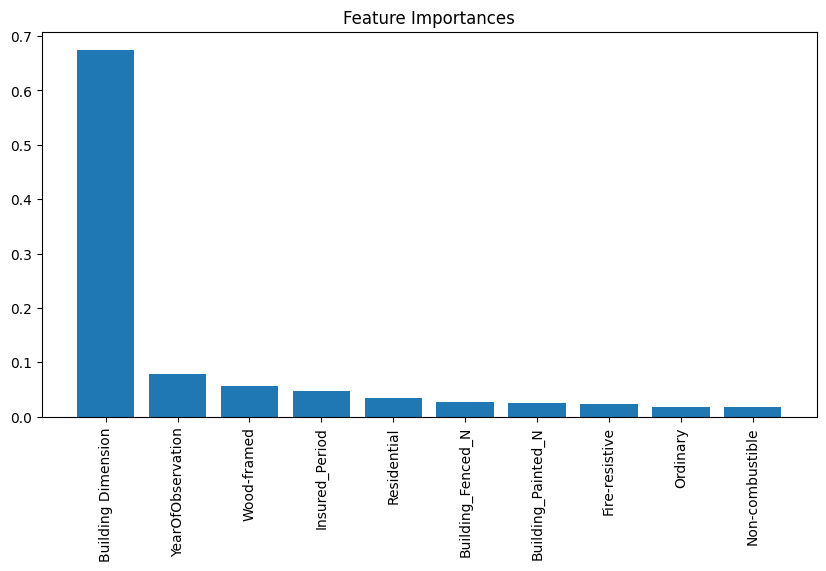

In [117]:
# Visualisation de random forest
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.show()

In [118]:
# Scores de Random Forest
scores(rfc, X_train, y_train, X_test, y_test)

Train Accuracy: 0.81
Test Accuracy: 0.77
F1 Train Score: 0.76
F1 Test Score: 0.71


In [119]:
# Modélisation avec un SVC
from sklearn.svm import SVC
svc = SVC(random_state=40, kernel='linear')
svc.fit(X_train, y_train)

SVC(kernel='linear', random_state=40)

In [120]:
# Scores de SVC
scores(svc, X_train, y_train, X_test, y_test)

Train Accuracy: 0.78
Test Accuracy: 0.76
F1 Train Score: 0.68
F1 Test Score: 0.66


In [121]:
# Identification de max_depth optimal pour GradientBoosting
from sklearn.ensemble import GradientBoostingClassifier

# Liste pour stocker les résultats
results = []

for x in range(1, 20):
    gbc = GradientBoostingClassifier(random_state=40, n_estimators=100, max_depth=x, max_features='sqrt')
    gbc.fit(X_train, y_train)
    
    # Calculer les scores d'exactitude
    train_score = gbc.score(X_train, y_train)
    test_score = gbc.score(X_test, y_test)
    
    # Prédictions
    y_train_pred = gbc.predict(X_train)
    y_test_pred = gbc.predict(X_test)
    
    # Calculer les scores F1
    F1_Train_Score = f1_score(y_train, y_train_pred, average='weighted')  # Utilisation de 'weighted' pour les classes déséquilibrées
    F1_Test_Score = f1_score(y_test, y_test_pred, average='weighted')
    
    # Ajouter les résultats dans la liste
    results.append({
        "max_depth": x, 
        "train_score": train_score, 
        "test_score": test_score,
        "F1_Train_Score": F1_Train_Score,
        "F1_Test_Score": F1_Test_Score
    })

# Convertir la liste en DataFrame
results_df = pd.DataFrame(results)

# Afficher le DataFrame
results_df.sort_values(by=["test_score","F1_Test_Score"] , ascending=False)


,max_depth,train_score,test_score,F1_Train_Score,F1_Test_Score
1,2,0.793296,0.768514,0.749104,0.716205
0,1,0.789904,0.768048,0.729803,0.701296
5,6,0.838188,0.766185,0.813489,0.723262
4,5,0.820032,0.765720,0.786433,0.713274
2,3,0.799481,0.763857,0.757973,0.707947
3,4,0.807462,0.763391,0.769137,0.707630
6,7,0.866720,0.757802,0.851061,0.711083
7,8,0.898643,0.755007,0.891140,0.722984
9,10,0.944932,0.735911,0.943678,0.715126
8,9,0.931165,0.734979,0.928660,0.706866


In [ ]:
# Modélisation avec un Gradient Boosting
gbc = GradientBoostingClassifier(random_state=40, n_estimators=100, max_depth=2, max_features='sqrt')
gbc.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=2, max_features='sqrt', random_state=40)

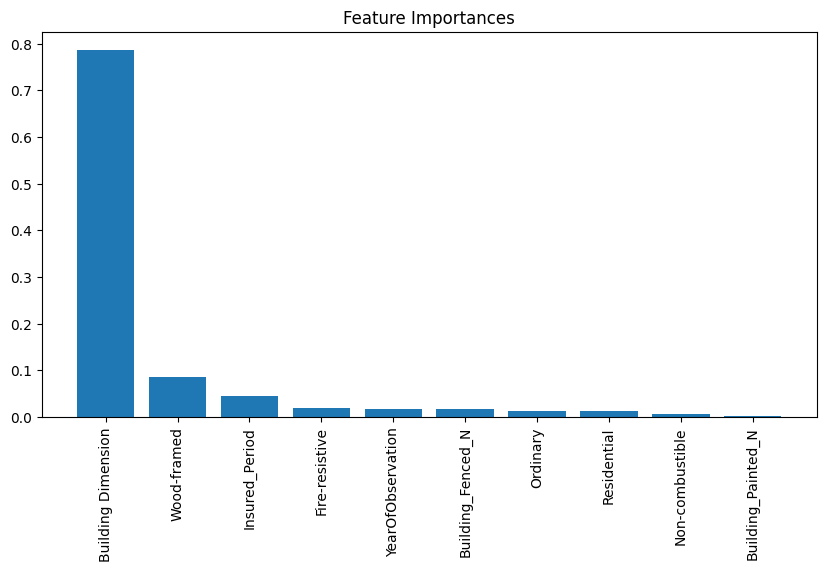

In [123]:
# Visualisation de Gradient Boosting
importances = gbc.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.show()


In [124]:
# Scores de Gradient Boosting
scores(gbc, X_train, y_train, X_test, y_test)

Train Accuracy: 0.79
Test Accuracy: 0.77
F1 Train Score: 0.75
F1 Test Score: 0.72


In [125]:
# Modélisation avec un MLPClassifier
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=40, hidden_layer_sizes=(100, 50), max_iter=1000)
mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=40)

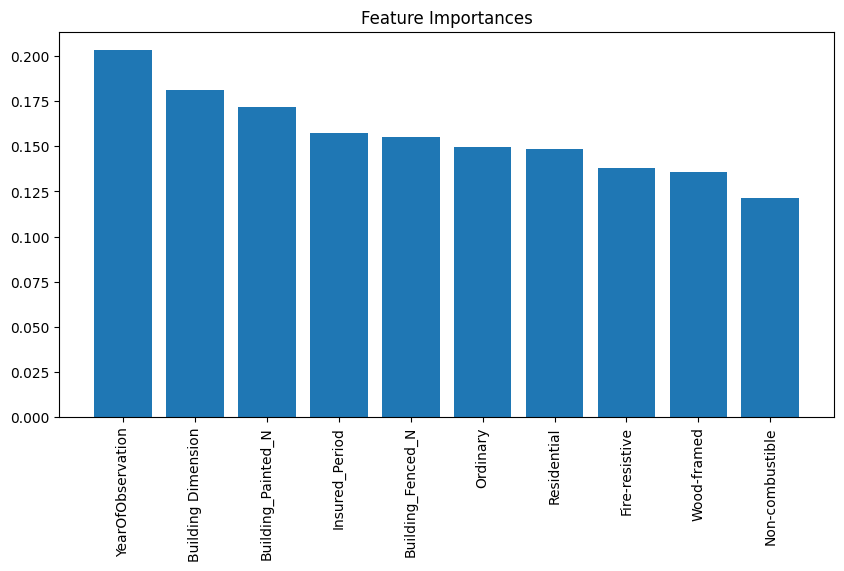

In [126]:
# Visualisation de MLPClassifier
importances = np.mean(np.abs(mlp.coefs_[0]), axis=1)
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.show()

In [127]:
# Scores de MLPClassifier
scores(mlp, X_train, y_train, X_test, y_test)

Train Accuracy: 0.8
Test Accuracy: 0.77
F1 Train Score: 0.77
F1 Test Score: 0.73


In [128]:
# Fonction pour comparer les modèles avec visualisation des scores
def compare_models(models, X_train, y_train, X_test, y_test):
    results = []
    for model in models:
        model_name = model.__class__.__name__
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        train_accuracy = accuracy_score(y_train, y_pred_train)
        test_accuracy = accuracy_score(y_test, y_pred_test)

        train_f1 = f1_score(y_train, y_pred_train, average='weighted')
        test_f1 = f1_score(y_test, y_pred_test, average='weighted')

        results.append([model_name, train_accuracy, test_accuracy, train_f1, test_f1])

    results_df = pd.DataFrame(results, columns=["Model", "Train Accuracy", "Test Accuracy", "Train F1", "Test F1"])
    return results_df

In [129]:
models = [dtc, rfc, svc, gbc, mlp]
compare_models(models, X_train, y_train, X_test, y_test)

,Model,Train Accuracy,Test Accuracy,Train F1,Test F1
0,DecisionTreeClassifier,0.797686,0.760130,0.760752,0.716751
1,RandomForestClassifier,0.807662,0.769912,0.764569,0.708832
2,SVC,0.775339,0.763391,0.677224,0.660960
3,GradientBoostingClassifier,0.793296,0.768514,0.749104,0.716205
4,MLPClassifier,0.802474,0.768048,0.770477,0.728373
